In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
# Load dataset
water_usage = pd.read_csv('Water Usage/SOC Outlet-1/Table.csv',
                          usecols=["Date", "Time", "Device Name", "water_flow_in_cubic_meter"])

# Reverse order if needed
data = water_usage[::-1]


#data = data.drop_duplicates(subset=["Date"], keep="first")  # Keep first occurrence

# Set index and ensure DateTime format
data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d-%m-%Y %H:%M:%S")
data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6H")

# Set the new Timestamp as index
data.set_index("Rounded_Timestamp", inplace=True)

# Drop the original "Date" and "Time" columns if no longer needed
data.drop(columns=["Date", "Time","Timestamp","Device Name"], inplace=True)


# Ensure daily frequency
data = data.resample("6H").mean() 

# Rename column
data.rename(columns={'water_flow_in_cubic_meter': 'Water_Consumption'}, inplace=True)
print(data.isna().sum())
data.interpolate(method="linear", inplace=True)
# Display first 20 rows
print(data.head(20))


Water_Consumption    109
dtype: int64
                     Water_Consumption
Rounded_Timestamp                     
2024-01-01 00:00:00            1214.70
2024-01-01 06:00:00            1214.70
2024-01-01 12:00:00            1214.70
2024-01-01 18:00:00            1214.70
2024-01-02 00:00:00            1214.70
2024-01-02 06:00:00            1214.70
2024-01-02 12:00:00            1215.30
2024-01-02 18:00:00            1220.10
2024-01-03 00:00:00            1220.10
2024-01-03 06:00:00            1222.50
2024-01-03 12:00:00            1232.00
2024-01-03 18:00:00            1240.10
2024-01-04 00:00:00            1246.55
2024-01-04 06:00:00            1248.60
2024-01-04 12:00:00            1254.50
2024-01-04 18:00:00            1261.00
2024-01-05 00:00:00            1265.00
2024-01-05 06:00:00            1267.90
2024-01-05 12:00:00            1273.30
2024-01-05 18:00:00            1280.20


C:\Users\tamil\AppData\Local\Temp\ipykernel_1800\917711674.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d-%m-%Y %H:%M:%S")
C:\Users\tamil\AppData\Local\Temp\ipykernel_1800\917711674.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6H")
C:\Users\tamil\AppData\Local\Temp\ipykernel_1800\917711674.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

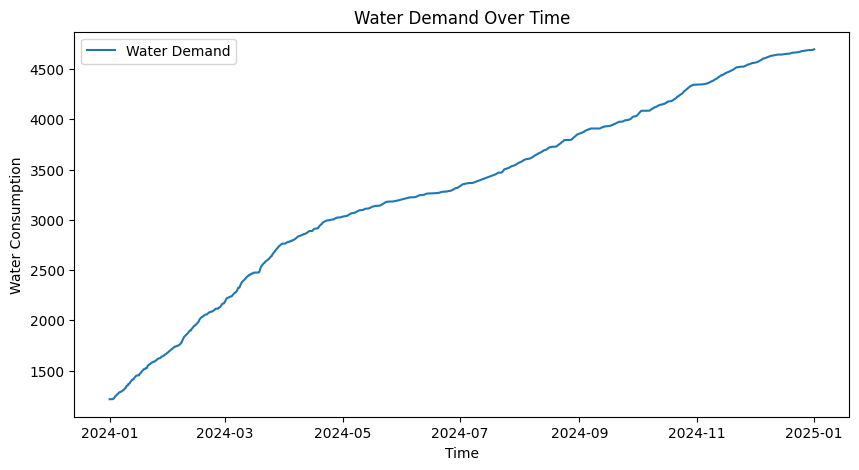

In [4]:
plt.figure(figsize=(10,5))
plt.plot(data["Water_Consumption"], label="Water Demand")
plt.xlabel("Time")
plt.ylabel("Water Consumption")
plt.title("Water Demand Over Time")
plt.legend()
plt.show()

In [5]:
# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")  
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is NOT Stationary")

# Check stationarity
check_stationarity(data["Water_Consumption"])


ADF Statistic: -3.8357577458084307
P-Value: 0.002561939220858776
Data is Stationary


ADF Statistic: -4.223940800760646
P-Value: 0.0006000415069450367
Data is Stationary


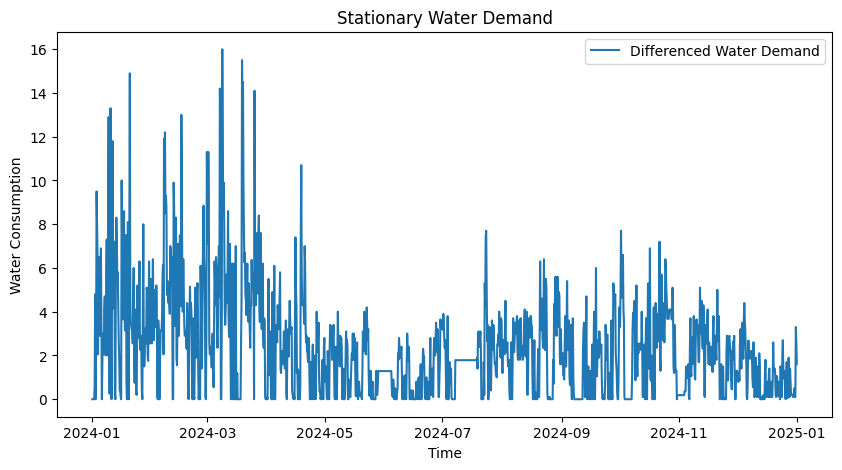

In [6]:
data["Water_Consumption_Diff"] = data["Water_Consumption"].diff()  # Compute first difference
df = data.dropna(subset=["Water_Consumption_Diff"])  # Drop NaN values

# Check stationarity again
check_stationarity(data["Water_Consumption_Diff"].dropna())

# Plot differenced data
plt.figure(figsize=(10,5))
plt.plot(data["Water_Consumption_Diff"], label="Differenced Water Demand")
plt.xlabel("Time")
plt.ylabel("Water Consumption")
plt.title("Stationary Water Demand")
plt.legend()
plt.show()

In [7]:
# Split into training (80%) and testing (20%)
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

In [1]:
pip install scikit-optimize


  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-25.1.0-py3-none-any.whl.metadata (12 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached pyaml-25.1.0-py3-none-any.whl (26 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\tamil\Python\python.exe -m pip install --upgrade pip


In [8]:
from skopt import gp_minimize
from skopt.space import Integer
import statsmodels.api as sm

def sarimax_aic(params):
    p, d, q, P, D, Q = params
    try:
        model = sm.tsa.statespace.SARIMAX(data["Water_Consumption"],
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, 7),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit()
        return results.aic
    except:
        return np.inf  # High AIC for failed models

search_space = [Integer(0, 2), Integer(0, 1), Integer(0, 2), Integer(0, 2), Integer(0, 1), Integer(0, 2)]
result = gp_minimize(sarimax_aic, search_space, n_calls=20, random_state=42)

print(f"✅ Best SARIMAX order: {result.x}")


C:\Users\tamil\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tamil\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tamil\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tamil\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Best SARIMAX order: [np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(0), np.int64(2)]


In [17]:
# Define SARIMAX model using the best parameters
model = SARIMAX(train_data["Water_Consumption"], 
                order=(1,1,2),  # Non-seasonal ARIMA part
                seasonal_order=(2,2,2,7),  # Seasonal ARIMA part
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Fit the model
fitted_model = model.fit()

# Print summary of model performance
print(fitted_model.summary())


C:\Users\tamil\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                 Water_Consumption   No. Observations:                 1172
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 7)   Log Likelihood               -2354.127
Date:                           Mon, 10 Mar 2025   AIC                           4724.253
Time:                                   21:55:44   BIC                           4764.564
Sample:                               01-01-2024   HQIC                          4739.476
                                    - 10-19-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5478      0.059     -9.261      0.000      -0.664      -0.432
ma.L1          1.2125      0.057     21.385

In [18]:
# Forecasting with Best Model
forecast_steps = len(test_data)  # Change based on future prediction needs
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = test_data.index
forecast_values = forecast.predicted_mean
forecast_df = pd.DataFrame({"Actual": test_data["Water_Consumption"], 
                            "Predicted": forecast_values}, index=forecast_index)

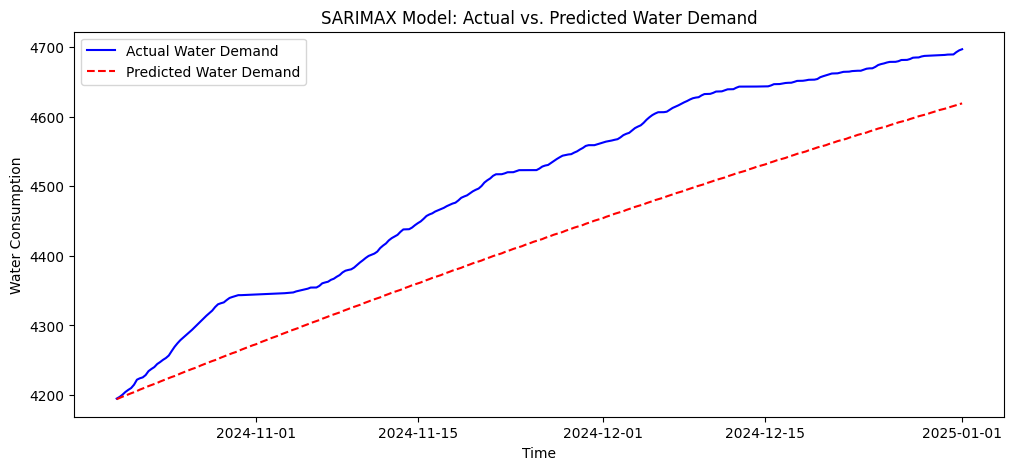

In [19]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test_data.index, test_data["Water_Consumption"], label="Actual Water Demand", color="blue")
plt.plot(forecast_index, forecast_values, label="Predicted Water Demand", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Water Consumption")
plt.legend()
plt.title("SARIMAX Model: Actual vs. Predicted Water Demand")
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_data["Water_Consumption"], forecast_values))
print(f"Test RMSE: {rmse:.2f}")

# Compute MAE
mae = mean_absolute_error(test_data["Water_Consumption"], forecast_values)
print(f"Test MAE: {mae:.2f}")


Test RMSE: 92.15
Test MAE: 87.42
